In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [62]:
# set categorical types
category_cols = ['Rating','Type','Status','Source','Premiered']
int_cols = ['Rank','Episodes','Scored By','Popularity','Favorites','Members']
float_cols = ['Score']

types = dict([(i,'category') for i in category_cols])

df = pd.read_csv('anime-dataset-2023.csv')
df = df.astype(types)
df.dtypes

anime_id           int64
Name              object
English name      object
Other name        object
Score             object
Genres            object
Synopsis          object
Type            category
Episodes          object
Aired             object
Premiered       category
Status          category
Producers         object
Licensors         object
Studios           object
Source          category
Duration          object
Rating          category
Rank              object
Popularity         int64
Favorites          int64
Scored By         object
Members            int64
Image URL         object
dtype: object

In [63]:
for cat in category_cols:
    print(cat)
    print(df[cat].cat.categories)

Rating
Index(['G - All Ages', 'PG - Children', 'PG-13 - Teens 13 or older',
       'R - 17+ (violence & profanity)', 'R+ - Mild Nudity', 'Rx - Hentai',
       'UNKNOWN'],
      dtype='object')
Type
Index(['Movie', 'Music', 'ONA', 'OVA', 'Special', 'TV', 'UNKNOWN'], dtype='object')
Status
Index(['Currently Airing', 'Finished Airing', 'Not yet aired'], dtype='object')
Source
Index(['4-koma manga', 'Book', 'Card game', 'Game', 'Light novel', 'Manga',
       'Mixed media', 'Music', 'Novel', 'Original', 'Other', 'Picture book',
       'Radio', 'Unknown', 'Visual novel', 'Web manga', 'Web novel'],
      dtype='object')
Premiered
Index(['UNKNOWN', 'fall 1963', 'fall 1965', 'fall 1966', 'fall 1967',
       'fall 1968', 'fall 1969', 'fall 1970', 'fall 1971', 'fall 1972',
       ...
       'winter 2016', 'winter 2017', 'winter 2018', 'winter 2019',
       'winter 2020', 'winter 2021', 'winter 2022', 'winter 2023',
       'winter 2024', 'winter 2025'],
      dtype='object', length=244)


## Clean Numeric Columns

In [64]:
for col in int_cols:
    df[col] = pd.to_numeric(df[col],errors='coerce').fillna(-1).astype('int64')
for col in float_cols:
    df[col] = pd.to_numeric(df[col],errors='coerce').fillna(-1).astype('float64')
print(len(df.index))
df.dtypes

24905


anime_id           int64
Name              object
English name      object
Other name        object
Score            float64
Genres            object
Synopsis          object
Type            category
Episodes           int64
Aired             object
Premiered       category
Status          category
Producers         object
Licensors         object
Studios           object
Source          category
Duration          object
Rating          category
Rank               int64
Popularity         int64
Favorites          int64
Scored By          int64
Members            int64
Image URL         object
dtype: object

In [65]:
# we drop the rows that have no score
df = df[df['Score'] > 0]
print(len(df.index))

df.head()

15692


,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26,"Apr 3, 1998 to Apr 24, 1999",...,Sunrise,Original,24 min per ep,R - 17+ (violence & profanity),41,43,78525,914193,1771505,https://cdn.myanimelist.net/images/anime/4/196...
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",Movie,1,"Sep 1, 2001",...,Bones,Original,1 hr 55 min,R - 17+ (violence & profanity),189,602,1448,206248,360978,https://cdn.myanimelist.net/images/anime/1439/...
2,6,Trigun,Trigun,トライガン,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",TV,26,"Apr 1, 1998 to Sep 30, 1998",...,Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,328,246,15035,356739,727252,https://cdn.myanimelist.net/images/anime/7/203...
3,7,Witch Hunter Robin,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),7.25,"Action, Drama, Mystery, Supernatural",Robin Sena is a powerful craft user drafted in...,TV,26,"Jul 3, 2002 to Dec 25, 2002",...,Sunrise,Original,25 min per ep,PG-13 - Teens 13 or older,2764,1795,613,42829,111931,https://cdn.myanimelist.net/images/anime/10/19...
4,8,Bouken Ou Beet,Beet the Vandel Buster,冒険王ビィト,6.94,"Adventure, Fantasy, Supernatural",It is the dark century and the people are suff...,TV,52,"Sep 30, 2004 to Sep 29, 2005",...,Toei Animation,Manga,23 min per ep,PG - Children,4240,5126,14,6413,15001,https://cdn.myanimelist.net/images/anime/7/215...


### Split the df

In [66]:
# calculate number of datapoints for train set
def split_dataset(df:object, train_set_ratio:float):
    """splits a dataset, with the size of train_set being determined by train_set_ratio
    @param df: The dataframe to split
    @param train_set_ratio: Float between 0 and 1 to determine the ratio of the df to be the train_set
    @returns train_set: The train set
    @returns test_set: The test set"""

    # shuffle the data so we don't just take the first 20% as test set.
    df = df.sample(frac=1).reset_index(drop=True)

    # calculate the splits
    entry_count = len(df.index)
    train_count = (int)(entry_count*train_set_ratio)

    # split
    train_set = df[:train_count]
    test_set = df[train_count:]

    print(f'total: {entry_count}\ntrain: {train_set.shape}\ntest: {test_set.shape}')
    return train_set, test_set

train_set, test_set = split_dataset(df,0.8)

total: 15692
train: (12553, 24)
test: (3139, 24)


### Linear Regression code yanked from Exercise 4

In [81]:
def linear_regression(x:str, y:str, train_set:object, test_set:object):
    """does linear regression of variable y in the dataset against x.
    @param x: The variable we want to predict
    @param y: The variable to perform regression on.
    @param train_set: The set used for training the model.
    @param test_set: The set used to test the model's accuracy.
    @returns R^2: The R^2 values of the model, train set then test set.
    @returns MSE: The MSE values of the model, train set then test set."""

    print(f'=============== {y} ===============')
    linreg = LinearRegression()
    linreg.fit(train_set[[y]],train_set[[x]])

    # print the intercept & coef in the form y = m*x + c
    print(f"""Line Equation
        {x} = {linreg.coef_}*{y} + {linreg.intercept_}
        """)

    datasets = {'train':train_set, 'test':test_set}
    results = {}

    r2_arr = []
    mse_arr = []
    
    for name,dataset in datasets.items():

        pred = linreg.predict(dataset[[y]])
        
        r2 = linreg.score(dataset[[y]], dataset[[x]])
        mse = mean_squared_error(dataset[[x]], pred)

        r2_arr.append(r2)
        mse_arr.append(mse)

        print(f"""{name} dataset
        R^2: {r2}
        MSE: {mse}
        """)
        results[name] = pred


    # Plot the Predictions vs the True values
    f, axes = plt.subplots(1, 2, figsize=(24, 12))
    axes[0].scatter(train_set[[x]], results['train'], color = "blue")
    axes[0].plot(train_set[[x]], train_set[[x]], linewidth = 1, color = 'black')
    axes[0].set_xlabel(f"True values of {x}")
    axes[0].set_ylabel(f"Predicted values of {x}")
    axes[1].scatter(test_set[[x]], results['test'], color = "green")
    axes[1].plot(test_set[[x]], test_set[[x]], linewidth = 1, color='black')
    axes[1].set_xlabel(f"True values of {x}")
    axes[1].set_ylabel(f"Predicted values of {x}")
    plt.show()
    return r2_arr, mse_arr

### Performing Linear Regression

=============== Rank ===============
Line Equation
        Score = [[-0.00013112]]*Rank + [7.05508419]
        
train dataset
        R^2: 0.3436173094981736
        MSE: 0.5646239465845694
        
test dataset
        R^2: 0.30337912851086657
        MSE: 0.6068201840934426
        


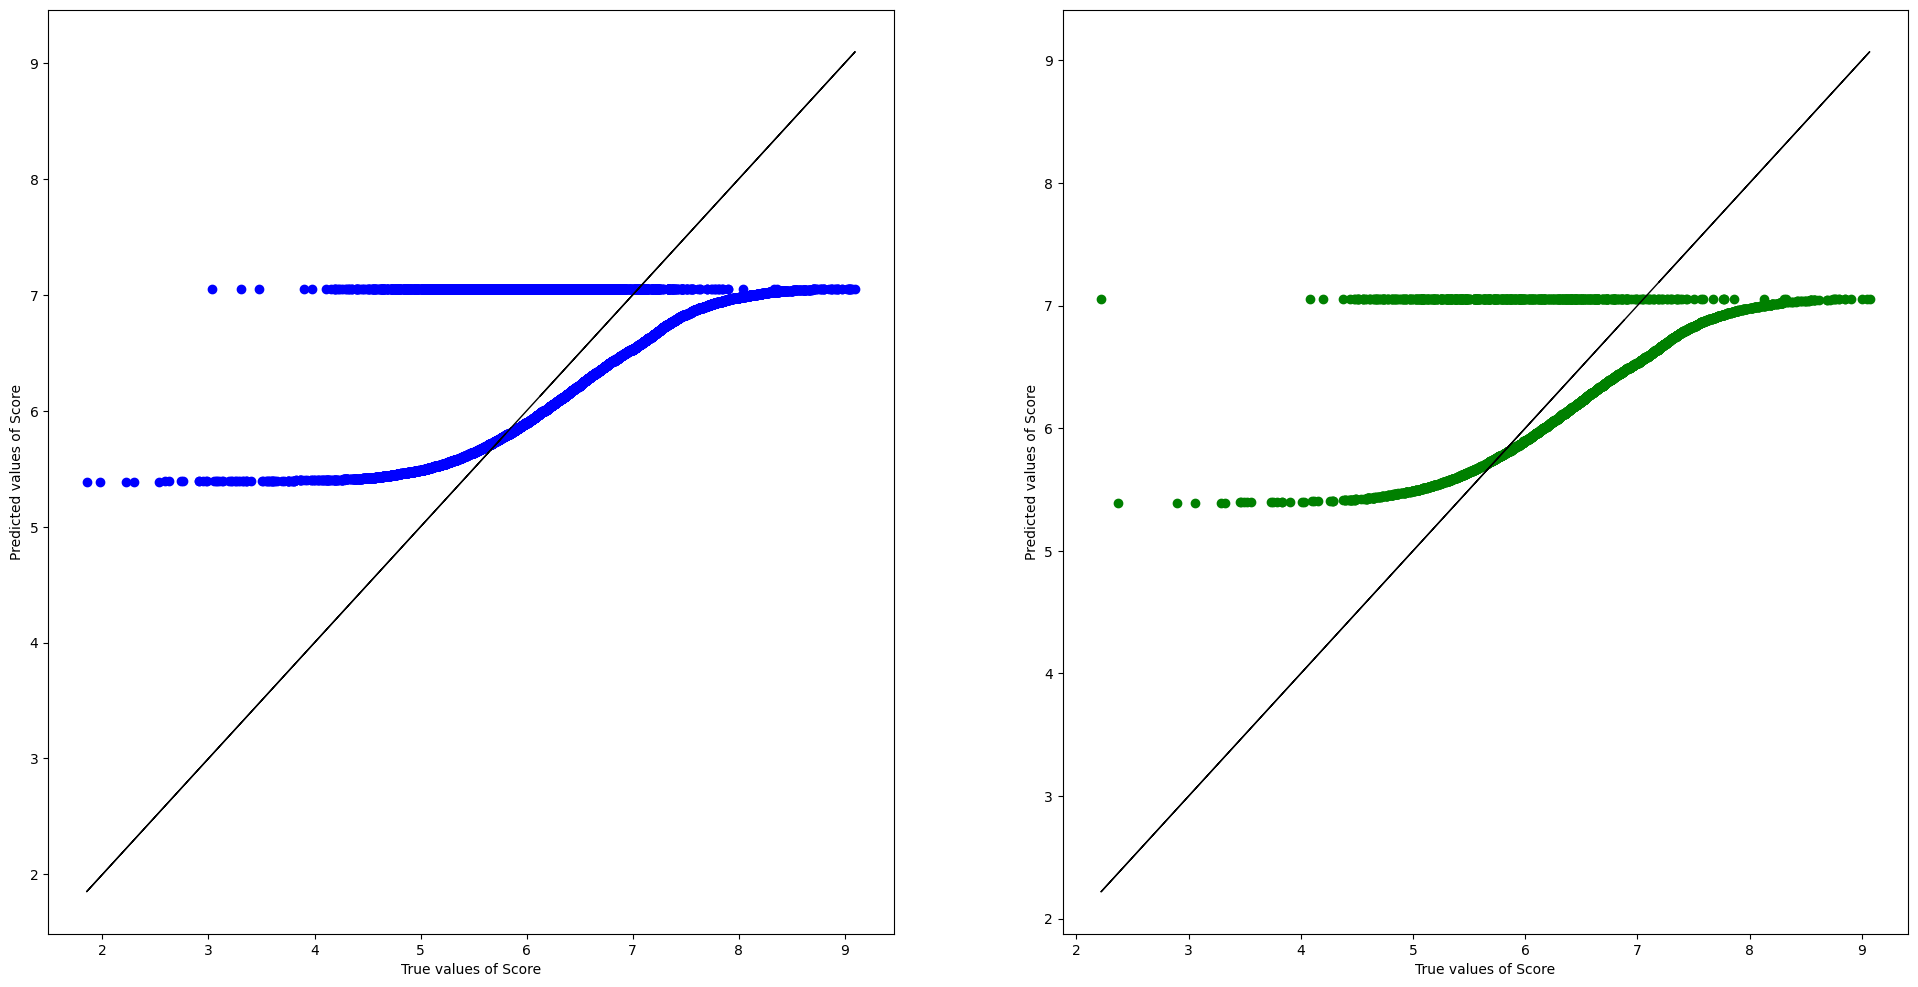

=============== Episodes ===============
Line Equation
        Score = [[0.00170751]]*Episodes + [6.35856172]
        
train dataset
        R^2: 0.006974205119802623
        MSE: 0.8542061688690676
        
test dataset
        R^2: 0.0023672064327017184
        MSE: 0.8690289657214307
        


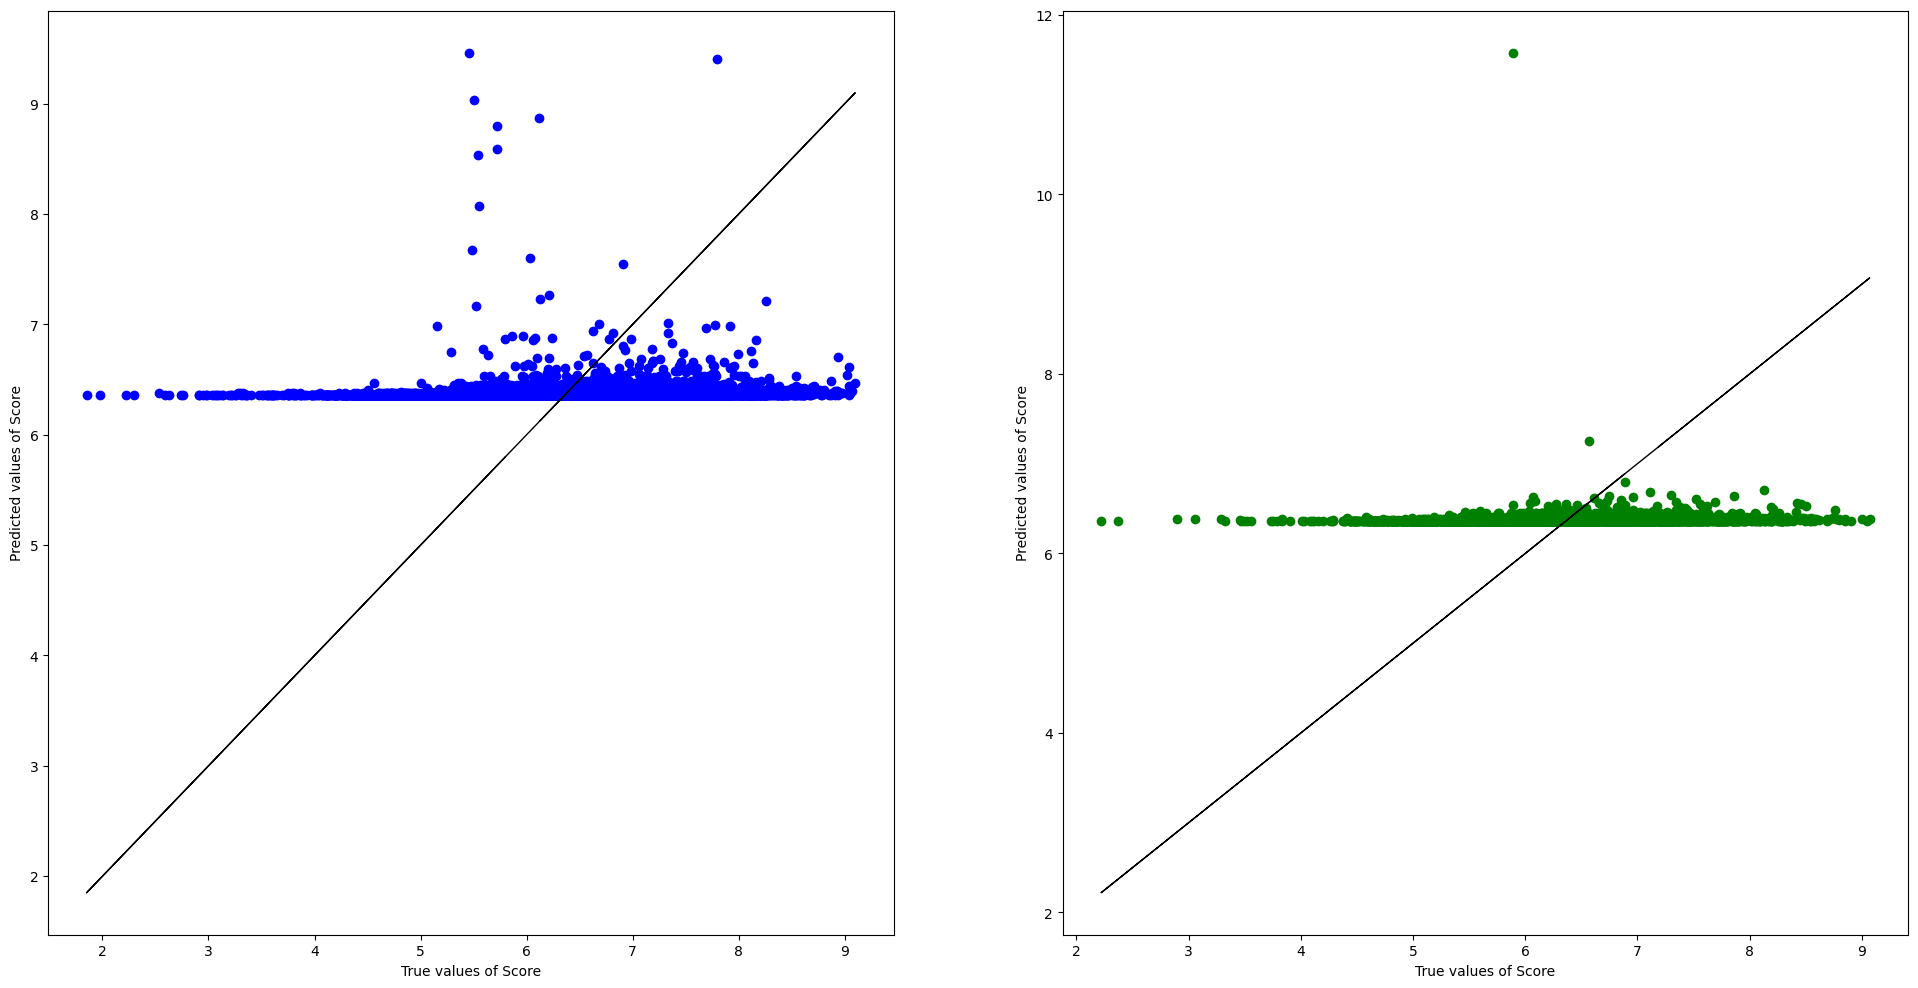

=============== Scored By ===============
Line Equation
        Score = [[2.71056197e-06]]*Scored By + [6.2958877]
        
train dataset
        R^2: 0.1227055575221434
        MSE: 0.7546534325118351
        
test dataset
        R^2: 0.12469314527160469
        MSE: 0.7624719391325652
        


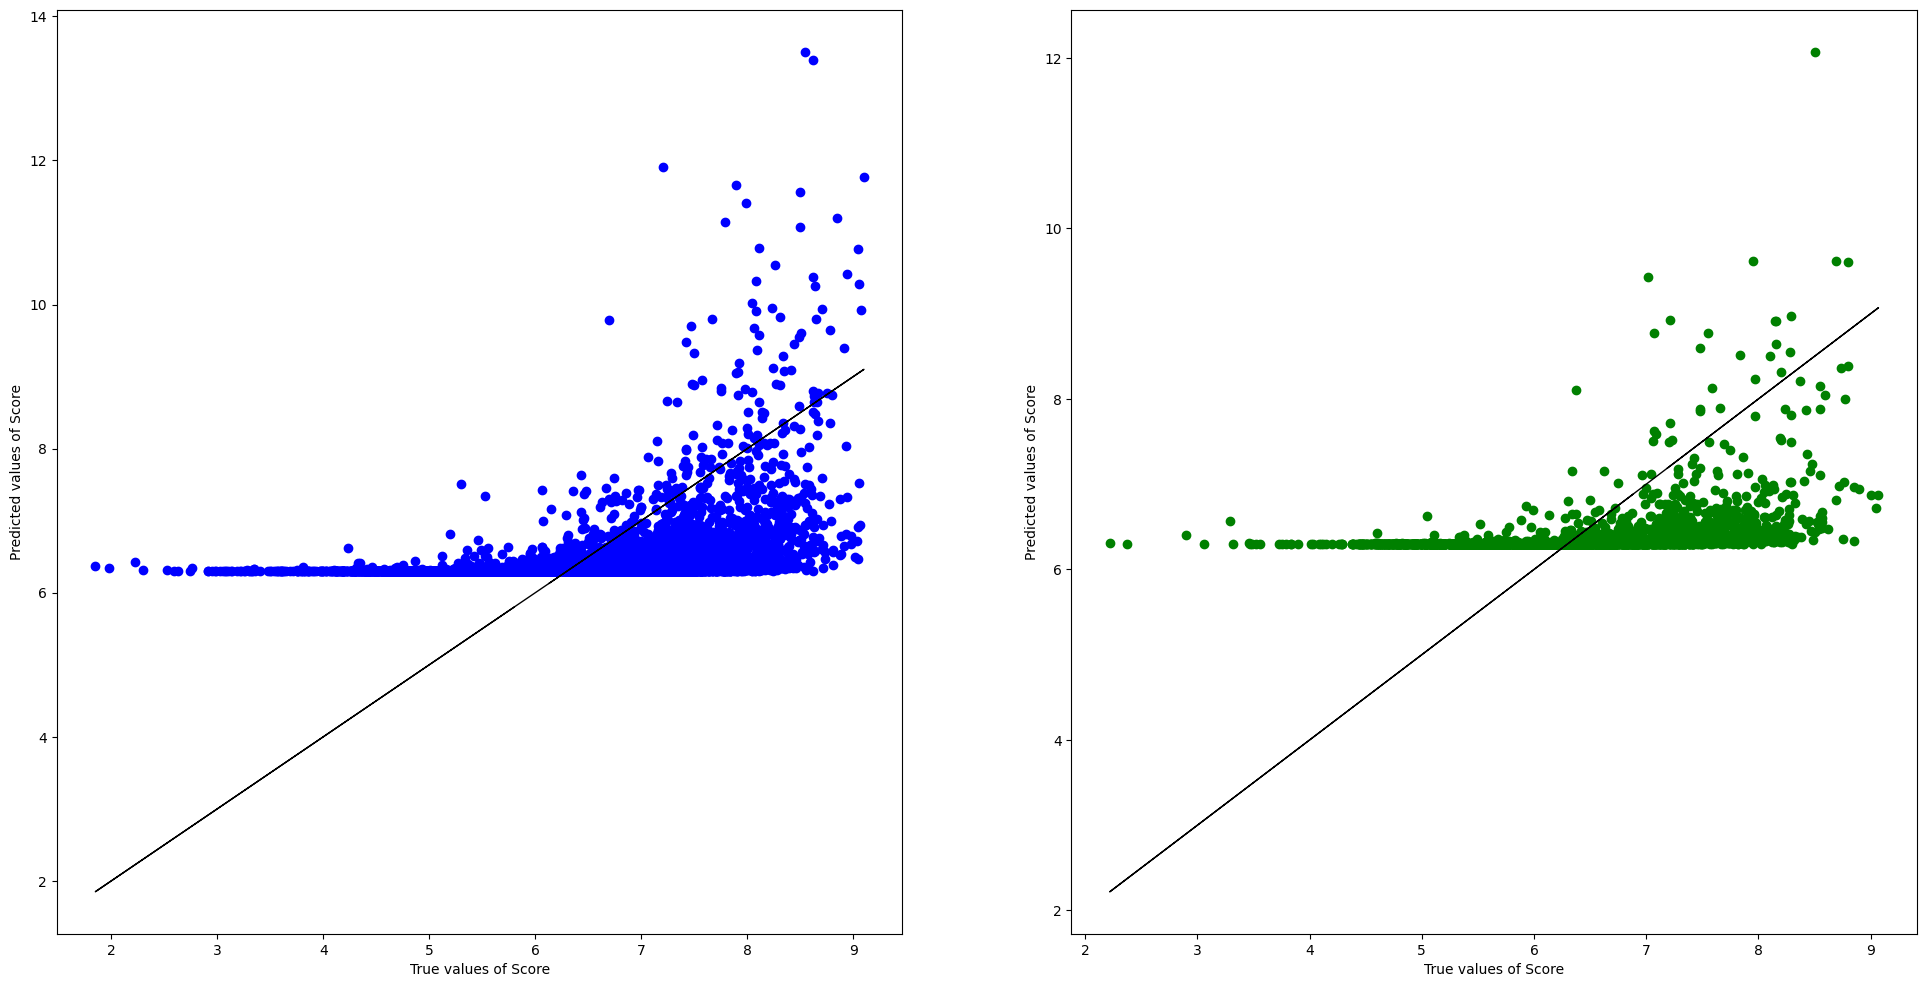

=============== Popularity ===============
Line Equation
        Score = [[-0.00013133]]*Popularity + [7.45924933]
        
train dataset
        R^2: 0.48223910305360174
        MSE: 0.44538072872936074
        
test dataset
        R^2: 0.5069545873544861
        MSE: 0.42948743041306536
        


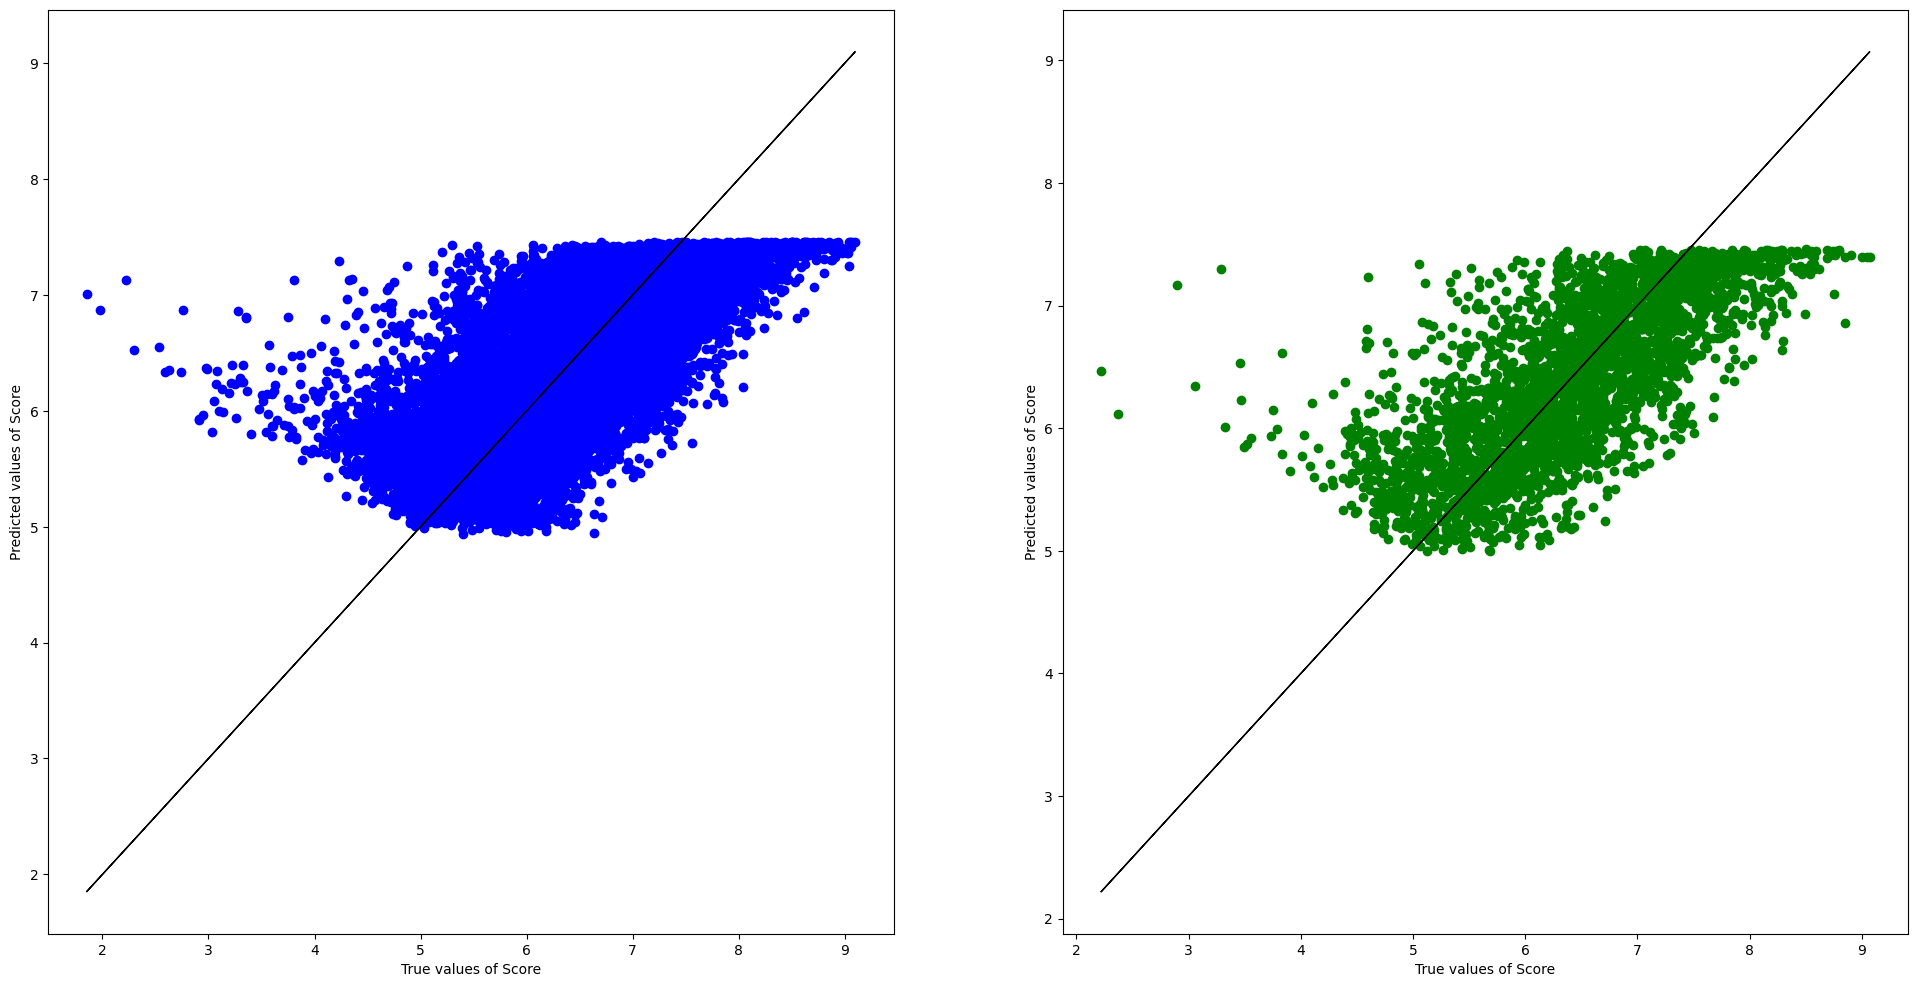

=============== Favorites ===============
Line Equation
        Score = [[3.8670642e-05]]*Favorites + [6.35084812]
        
train dataset
        R^2: 0.05528536022860964
        MSE: 0.8126486514995294
        
test dataset
        R^2: 0.05546196787259117
        MSE: 0.8227785959292104
        


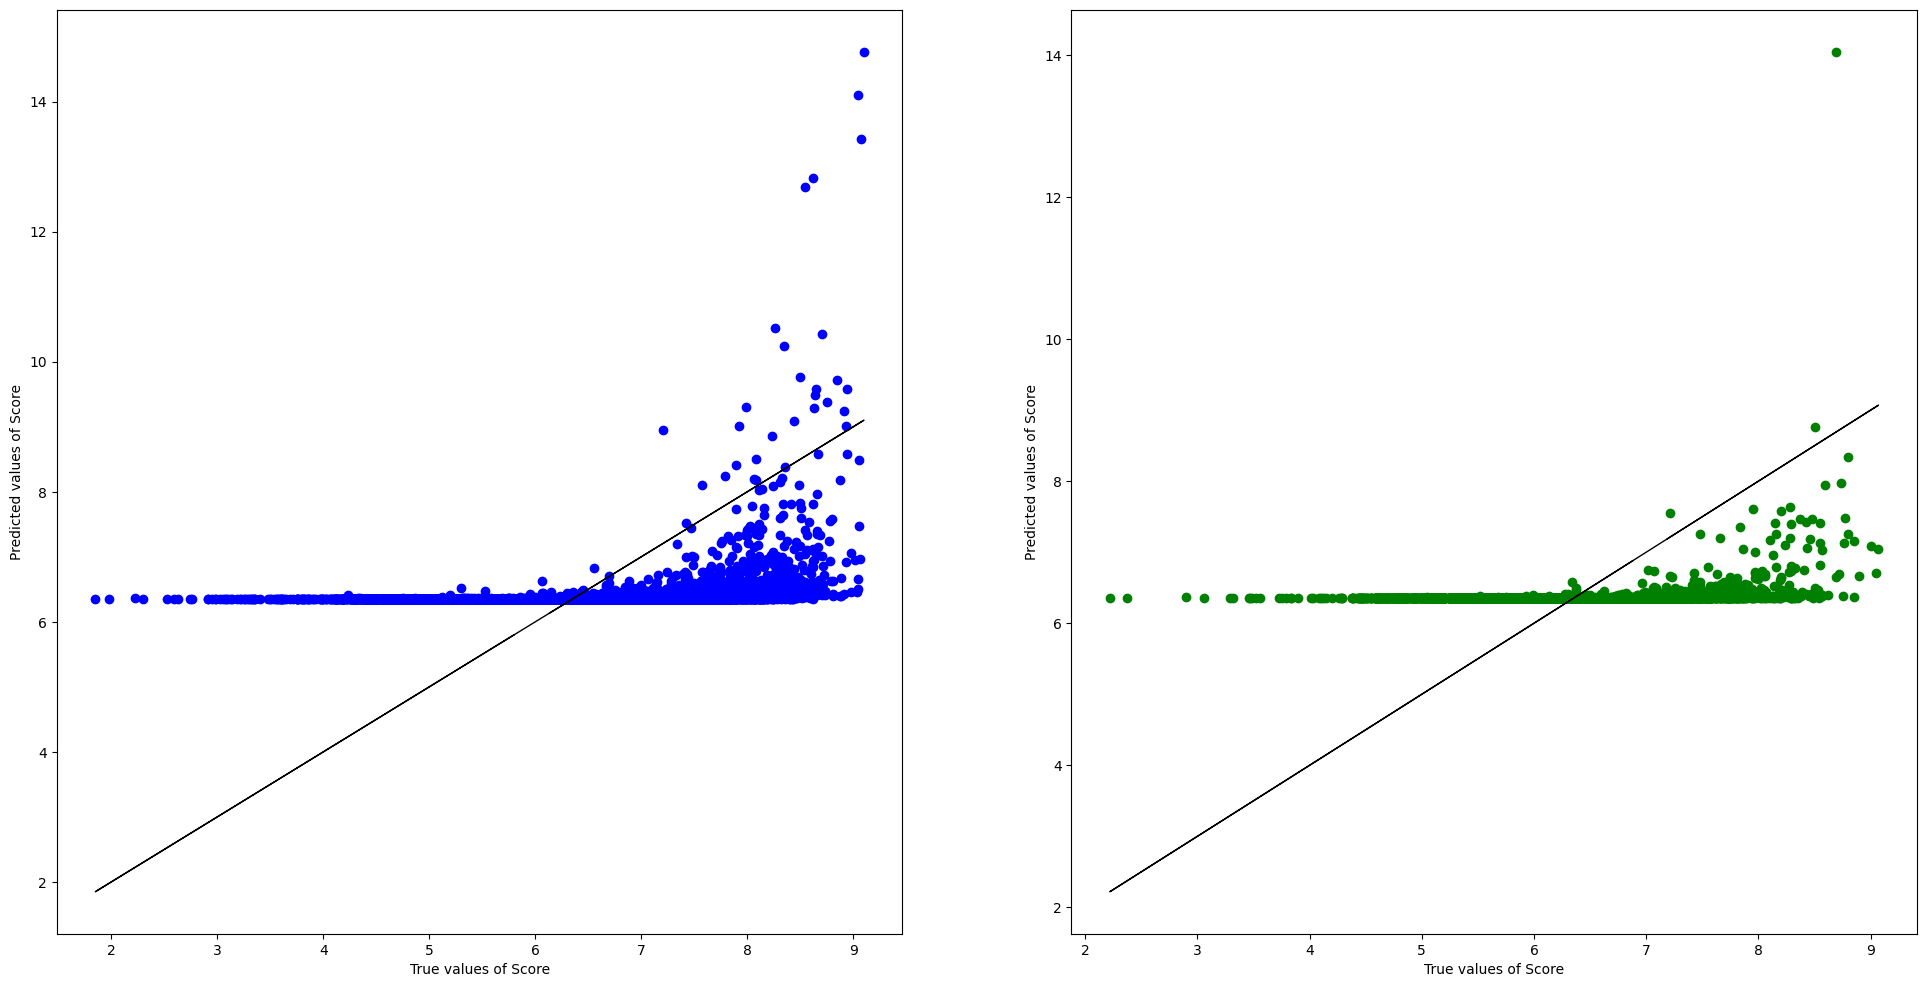

=============== Members ===============
Line Equation
        Score = [[1.8271677e-06]]*Members + [6.27091734]
        
train dataset
        R^2: 0.15212820789276826
        MSE: 0.7293439092540857
        
test dataset
        R^2: 0.15493885266923968
        MSE: 0.7361251750859533
        


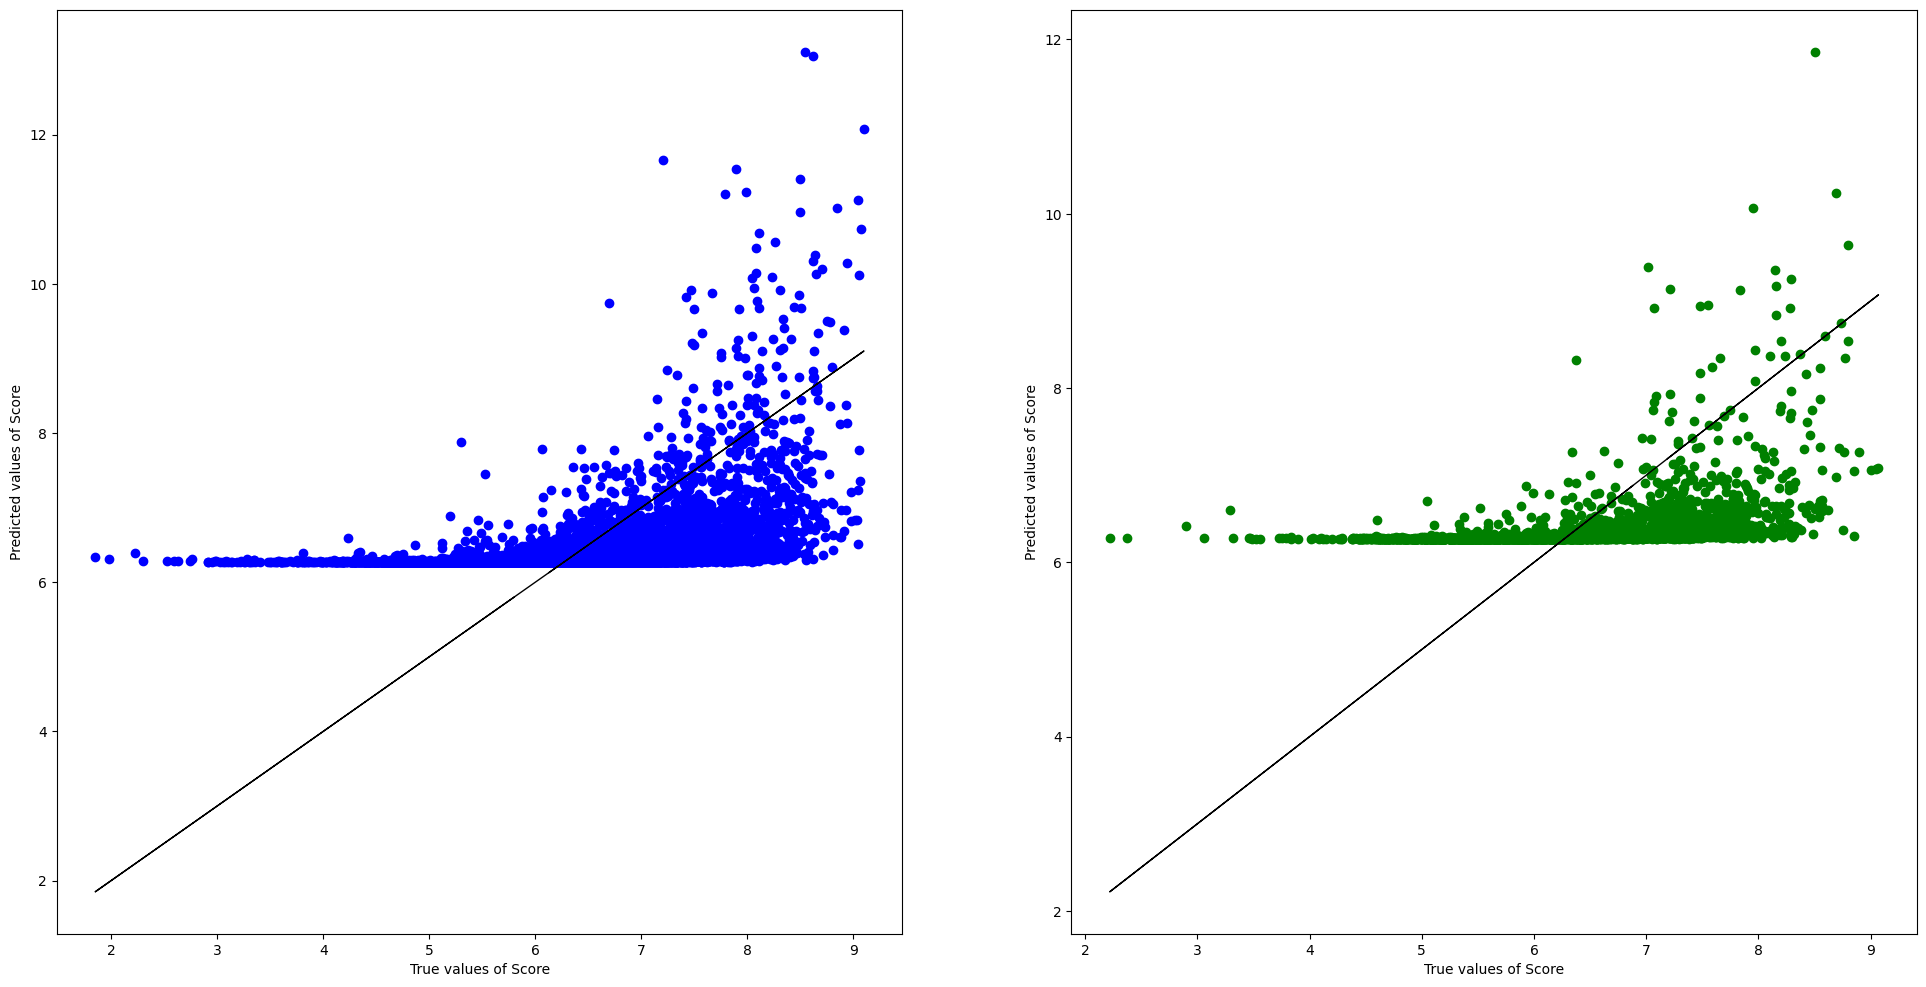

Rank regression
0 dataset
        R^2: 0.3436173094981736
        MSE: 0.5646239465845694
        
1 dataset
        R^2: 0.30337912851086657
        MSE: 0.6068201840934426
        
Episodes regression
0 dataset
        R^2: 0.006974205119802623
        MSE: 0.8542061688690676
        
1 dataset
        R^2: 0.0023672064327017184
        MSE: 0.8690289657214307
        
Scored By regression
0 dataset
        R^2: 0.1227055575221434
        MSE: 0.7546534325118351
        
1 dataset
        R^2: 0.12469314527160469
        MSE: 0.7624719391325652
        
Popularity regression
0 dataset
        R^2: 0.48223910305360174
        MSE: 0.44538072872936074
        
1 dataset
        R^2: 0.5069545873544861
        MSE: 0.42948743041306536
        
Favorites regression
0 dataset
        R^2: 0.05528536022860964
        MSE: 0.8126486514995294
        
1 dataset
        R^2: 0.05546196787259117
        MSE: 0.8227785959292104
        
Members regression
0 dataset
        R^2: 0.15212820789276

In [82]:
regs = dict([(y , {}) for y in int_cols])
for y in int_cols:
    regs[y]['r2'], regs[y]['mse'] = linear_regression('Score',y,train_set=train_set, test_set=test_set)

for name, res in regs.items():
    print(f"{name} regression")
    for i in range(len(res['r2'])):
        print(f"""{i} dataset
        R^2: {res['r2'][i]}
        MSE: {res['mse'][i]}
        """)


### Categorical Data

In [84]:
def plot_categories(x,y):
    """plot the boxplot of x against y, as well as the countplot of y.
    @param x: The variable to be investigated
    @param y: The categorical data"""
    print(f'=============== {y} ===============')
    df2 = df[[y, x]].astype({y:'category'}) # need to set variable as category
    cats = df2[y].cat.categories
    sb.countplot(data=df2[y])
    plt.show()
    print(f'categories: {len(cats)}')
    
    sb.boxplot(data=df2, x=x,y=y,orient='h')
    plt.show()

=============== Rating ===============


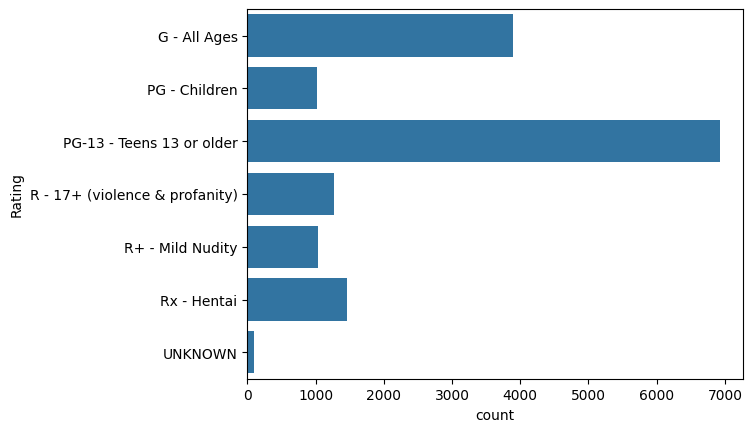

categories: 7


c:\ProgramData\miniconda3\envs\sc\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


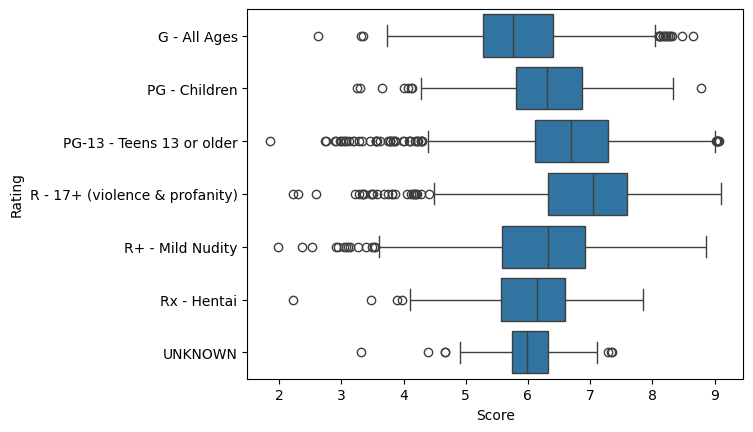

=============== Type ===============


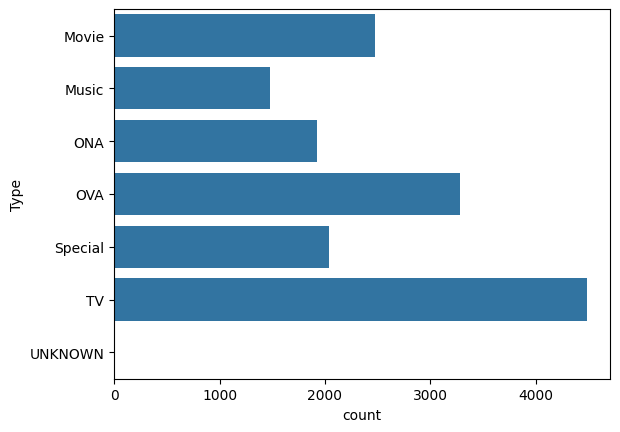

categories: 7


c:\ProgramData\miniconda3\envs\sc\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


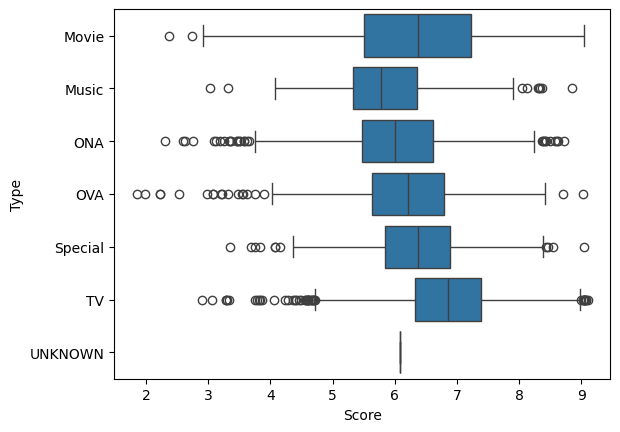

=============== Status ===============


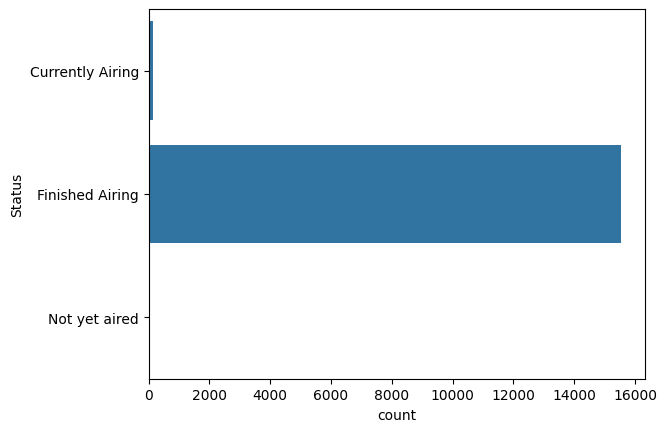

categories: 3


c:\ProgramData\miniconda3\envs\sc\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


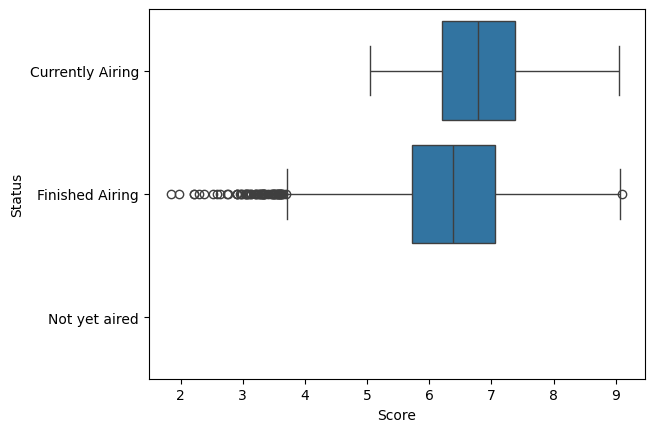

=============== Source ===============


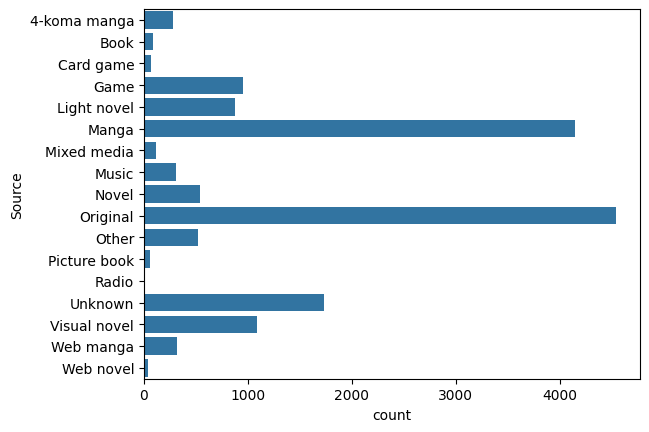

categories: 17


c:\ProgramData\miniconda3\envs\sc\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


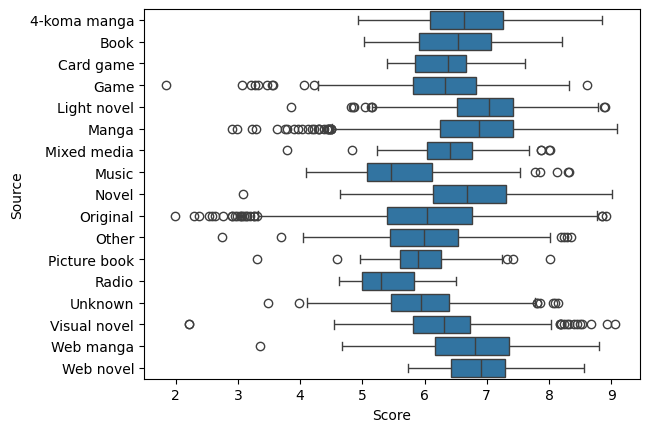

=============== Premiered ===============


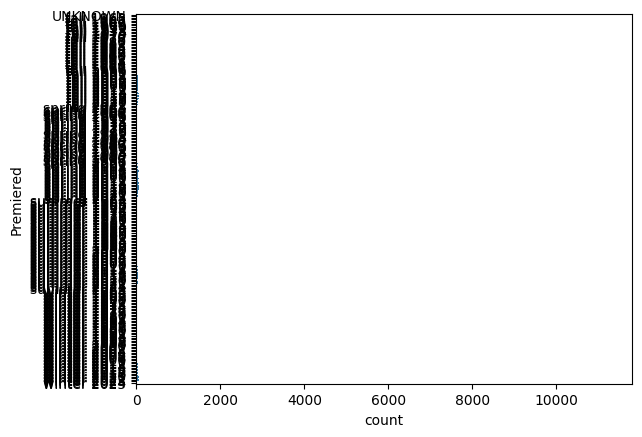

categories: 244


c:\ProgramData\miniconda3\envs\sc\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


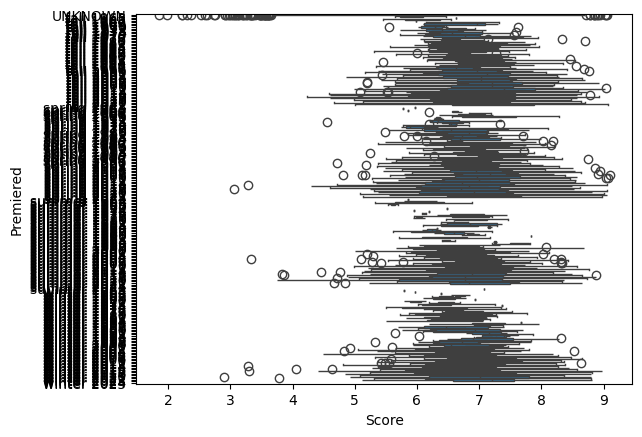

In [85]:
for y in category_cols:
    plot_categories('Score',y)